# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which we'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, [Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. we'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Let's make a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals.

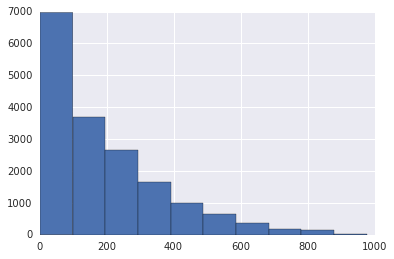

In [3]:
plt.hist(bike_rentals["cnt"])
plt.show()

Most of the times there are between 0 to 300 bikes rented as the same time. It's unusual that there are more than 600 at the same time rented.

Let's see with the corr() function if some columns are correlated to our cnt columns

In [4]:
bike_rentals.corr()["cnt"].sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

### Features

It can be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [5]:
def assign_label(hour):
    if  6 < hour <= 12:
        return 1
    elif  12 < hour <= 18:
        return 2
    elif  18 < hour <= 25:
        return 3
    else:
        return 4
    
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

In [6]:
bike_rentals["time_label"].head()

0    4
1    4
2    4
3    4
4    4
Name: time_label, dtype: int64

### Train and Test

Before we can begin applying machine learning algorithms, we'll need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set.

The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [7]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

We're ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

We need to ignore the casual and registered columns because cnt is derived from them.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 


features = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
        'time_label']
target = "cnt"

lr = LinearRegression()
lr.fit(train[features],train[target])
predictions = lr.predict(test[features])
mse = mean_squared_error(test[target],predictions)
mse

15019.947452531309

### Errors & Decision Tree

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

Let's now try with a decision tree algorithm.

In [9]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(train[features],train[target])
predictions = dt.predict(test[features])
mse = mean_squared_error(test[target],predictions)
mse

2922.1185270425776

We obtain some much better results! Let's try to see if we can improve them by experimenting with various parameters including min_samples_leaf, to see if it changes the error.

One of the risk of the decision tree is overfitting. Let's compute each time the mse for the train and for the test datasets.

In [10]:
dt = DecisionTreeRegressor(min_samples_leaf = 5 )
dt.fit(train[features],train[target])
predictions = dt.predict(test[features])
mse_test = mean_squared_error(test[target],predictions)
print(mse_test)

dt = DecisionTreeRegressor(min_samples_leaf = 5 )
dt.fit(train[features],train[target])
predictions = dt.predict(train[features])
mse_train = mean_squared_error(train[target],predictions)
print(mse_train)

2518.7534506991087
1056.346058290491


By setting the min_samples_leaf we can already see some improvements in our MSE.

### Random Forests

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

We can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [11]:
from sklearn.ensemble import RandomForestRegressor 

RF = RandomForestRegressor()
RF.fit(train[features],train[target])
predictions = RF.predict(test[features])
mse_test = mean_squared_error(test[target],predictions)
print(mse_test)

1796.1042433831992


Now let's modify the parameters to improve our predictions

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
RF = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
RF_random.fit(train[features],train[target])

rf_random.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] max_features=sqrt, max_depth=50, min_samples_leaf=2, bootstrap=True, n_estimators=50, min_samples_split=10 
[CV] max_features=sqrt, max_depth=50, min_samples_leaf=2, bootstrap=True, n_estimators=50, min_samples_split=10 
[CV] max_features=sqrt, max_depth=50, min_samples_leaf=2, bootstrap=True, n_estimators=50, min_samples_split=10 
[CV] max_features=sqrt, max_depth=90, min_samples_leaf=4, bootstrap=False, n_estimators=150, min_samples_split=10 
[CV] max_features=sqrt, max_depth=90, min_samples_leaf=4, bootstrap=False, n_estimators=150, min_samples_split=10 
[CV] max_features=sqrt, max_depth=90, min_samples_leaf=4, bootstrap=False, n_estimators=150, min_samples_split=10 
[CV] max_features=auto, max_depth=60, min_samples_leaf=2, bootstrap=False, n_estimators=150, min_samples_split=2 
[CV] max_features=auto, max_depth=60, min_samples_leaf=2, bootstrap=False, n_estimators=150, min_samples_split=2 
[CV] max_features=auto, ma

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.9s


[CV] max_features=auto, max_depth=100, min_samples_leaf=4, bootstrap=True, n_estimators=300, min_samples_split=2 
[CV]  max_features=sqrt, max_depth=10, min_samples_leaf=2, bootstrap=True, n_estimators=50, min_samples_split=5 -   1.0s
[CV] max_features=auto, max_depth=100, min_samples_leaf=4, bootstrap=True, n_estimators=300, min_samples_split=2 
[CV]  max_features=sqrt, max_depth=10, min_samples_leaf=2, bootstrap=True, n_estimators=50, min_samples_split=5 -   0.4s
[CV] max_features=auto, max_depth=100, min_samples_leaf=4, bootstrap=True, n_estimators=300, min_samples_split=2 
[CV]  max_features=sqrt, max_depth=10, min_samples_leaf=2, bootstrap=True, n_estimators=50, min_samples_split=5 -   0.4s
[CV] max_features=auto, max_depth=50, min_samples_leaf=2, bootstrap=True, n_estimators=500, min_samples_split=5 
[CV]  max_features=sqrt, max_depth=30, min_samples_leaf=1, bootstrap=True, n_estimators=350, min_samples_split=5 -   4.6s
[CV] max_features=auto, max_depth=50, min_samples_leaf=2, bo